In [33]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess

#### Load an example image

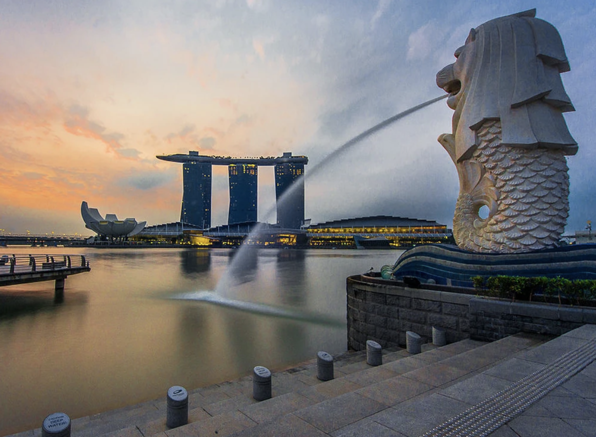

In [34]:
raw_image = Image.open("../docs/_static/merlion.png").convert("RGB")
display(raw_image.resize((596, 437)))

In [35]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load BLIP feature extractor

In [36]:
model, vis_processors, _ = load_model_and_preprocess("blip_feature_extractor", model_type="base", is_eval=True, device=device)

#### Specify class names

In [37]:
cls_names = ["merlion", "sky", "giraffe", "fountain", "marina bay"]

# (optional) add prompt when we want to use the model for zero-shot classification
from lavis.processors.blip_processors import BlipCaptionProcessor
text_processor = BlipCaptionProcessor(prompt="A picture of ")

cls_prompt = [text_processor(cls_nm) for cls_nm in cls_names]

In [42]:
cls_prompt

['A picture of merlion',
 'A picture of sky',
 'A picture of giraffe',
 'A picture of fountain',
 'A picture of marina bay']

In [39]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

#### Extract image embedding and class name embeddings

In [40]:
sample = {"image": image, "text_input": cls_names}

image_features = model.extract_features(sample, mode="image").image_embeds_proj[:, 0]
text_features = model.extract_features(sample, mode="text").text_embeds_proj[:, 0]

#### Matching image embeddings with each class name embeddings

In [41]:
sims = (image_features @ text_features.t())[0] / model.temp
probs = torch.nn.Softmax(dim=0)(sims).tolist()

for cls_nm, prob in zip(cls_names, probs):
    print(f"{cls_nm}: \t {prob:.3%}")

merlion: 	 82.005%
sky: 	 0.011%
giraffe: 	 0.000%
fountain: 	 1.060%
marina bay: 	 16.924%
